# Load and check datasets

In [1]:
import pyspark
print(pyspark.__version__)

3.5.0


In [2]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("MovieLensAnalysis") \
    .getOrCreate()


spark

In [3]:
# Load movies.csv from HDFS
movies_df = spark.read.csv("hdfs://namenode:8020/user/hadoop/movielens/movies.csv", header=True, inferSchema=True)

movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [4]:
# Load tags.csv from HDFS
tags_df = spark.read.csv("hdfs://namenode:8020/user/hadoop/movielens/tags.csv", header=True, inferSchema=True)

tags_df.show()

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    22|  26479|         Kevin Kline|1583038886|
|    22|  79592|            misogyny|1581476297|
|    22| 247150|          acrophobia|1622483469|
|    34|   2174|               music|1249808064|
|    34|   2174|               weird|1249808102|
|    34|   8623|        Steve Martin|1249808497|
|    55|   5766|the killls and th...|1319322078|
|    58|   7451|            bullying|1672551536|
|    58|   7451|              clique|1672551510|
|    58|   7451|       coming of age|1672551502|
|    58|   7451|              gossip|1672551527|
|    58|   7451|         high school|1672551496|
|    58|   7451|          teen movie|1672551500|
|    58|  49272|           '60s feel|1672551430|
|    58|  49272|                 007|1672551409|
|    58|  49272|              action|1672551403|
|    58|  49272|            assassin|1672551425|
|    58|  49272|    

In [5]:
# Load links.csv from HDFS
links_df = spark.read.csv("hdfs://namenode:8020/user/hadoop/movielens/links.csv", header=True, inferSchema=True)

links_df.show()



+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



After accessing this dataset, which is simply links to IMDB and TMDB, it simply isn't worth analyzing, so we won't be using it but for display

In [6]:
# Load ratings.csv from HDFS
ratings_df = spark.read.csv("hdfs://namenode:8020/user/hadoop/movielens/ratings.csv", header=True, inferSchema=True)

ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
|     1|     34|   2.0|943228491|
|     1|     36|   1.0|944249008|
|     1|     80|   5.0|944248943|
|     1|    110|   3.0|943231119|
|     1|    111|   5.0|944249008|
|     1|    161|   1.0|943231162|
|     1|    166|   5.0|943228442|
|     1|    176|   4.0|944079496|
|     1|    223|   3.0|944082810|
|     1|    232|   5.0|943228442|
|     1|    260|   5.0|943228696|
|     1|    302|   4.0|944253272|
|     1|    306|   5.0|944248888|
|     1|    307|   5.0|944253207|
|     1|    322|   4.0|944053801|
+------+-------+------+---------+
only showing top 20 rows



# Preprocessing

## Preprocessing Movies Data

In [7]:
from pyspark.sql.functions import regexp_extract

# Extract the year from the title using regex
movies_df = movies_df.withColumn("year", regexp_extract(movies_df["title"], r'\((\d{4})\)', 1))

# Clean title by removing the year
movies_df = movies_df.withColumn("clean_title", regexp_extract(movies_df["title"], r'^(.*)\s\(\d{4}\)$', 1))

# Create new DataFrame and drop the original 'title' column
split_movies_df = movies_df.drop("title")

# Show the resulting DataFrame
split_movies_df.show()



+-------+--------------------+----+--------------------+
|movieId|              genres|year|         clean_title|
+-------+--------------------+----+--------------------+
|      1|Adventure|Animati...|1995|           Toy Story|
|      2|Adventure|Childre...|1995|             Jumanji|
|      3|      Comedy|Romance|1995|    Grumpier Old Men|
|      4|Comedy|Drama|Romance|1995|   Waiting to Exhale|
|      5|              Comedy|1995|Father of the Bri...|
|      6|Action|Crime|Thri...|1995|                Heat|
|      7|      Comedy|Romance|1995|             Sabrina|
|      8|  Adventure|Children|1995|        Tom and Huck|
|      9|              Action|1995|        Sudden Death|
|     10|Action|Adventure|...|1995|           GoldenEye|
|     11|Comedy|Drama|Romance|1995|American Presiden...|
|     12|       Comedy|Horror|1995|Dracula: Dead and...|
|     13|Adventure|Animati...|1995|               Balto|
|     14|               Drama|1995|               Nixon|
|     15|Action|Adventure|...|1

## Preprocessing Tags Data

I think the time that a user tags a certain movie is less useful and can depend on different factors like when the user finishes his movie, so I took it out. We also have the release year of the movie which is enough for trend analysis.

In [8]:
# Drop the 'timestamp' column from tags_df
tags_df_clean = tags_df.drop("timestamp")

# Show the updated DataFrame
tags_df_clean.show()



+------+-------+--------------------+
|userId|movieId|                 tag|
+------+-------+--------------------+
|    22|  26479|         Kevin Kline|
|    22|  79592|            misogyny|
|    22| 247150|          acrophobia|
|    34|   2174|               music|
|    34|   2174|               weird|
|    34|   8623|        Steve Martin|
|    55|   5766|the killls and th...|
|    58|   7451|            bullying|
|    58|   7451|              clique|
|    58|   7451|       coming of age|
|    58|   7451|              gossip|
|    58|   7451|         high school|
|    58|   7451|          teen movie|
|    58|  49272|           '60s feel|
|    58|  49272|                 007|
|    58|  49272|              action|
|    58|  49272|            assassin|
|    58|  49272|         bittersweet|
|    58|  49272|              casino|
|    58|  49272|        Daniel Craig|
+------+-------+--------------------+
only showing top 20 rows



## Preprocessing Ratings Data

In [9]:
# Drop the timestamp column
ratings_df_clean = ratings_df.drop("timestamp")

# Show the cleaned DataFrame without the timestamp
ratings_df_clean.show()


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|     17|   4.0|
|     1|     25|   1.0|
|     1|     29|   2.0|
|     1|     30|   5.0|
|     1|     32|   5.0|
|     1|     34|   2.0|
|     1|     36|   1.0|
|     1|     80|   5.0|
|     1|    110|   3.0|
|     1|    111|   5.0|
|     1|    161|   1.0|
|     1|    166|   5.0|
|     1|    176|   4.0|
|     1|    223|   3.0|
|     1|    232|   5.0|
|     1|    260|   5.0|
|     1|    302|   4.0|
|     1|    306|   5.0|
|     1|    307|   5.0|
|     1|    322|   4.0|
+------+-------+------+
only showing top 20 rows



In [10]:
# Join tags_df_clean and ratings_df_clean on both 'movieId' and 'userId'
movies_tags_ratings_df = tags_df_clean.join(ratings_df_clean, on=["movieId", "userId"], how="inner")

# Join the result with split_movies_df on 'movieId' to get the genre, year, and title
merged_df = movies_tags_ratings_df.join(split_movies_df, on="movieId", how="inner")

# Show the final merged DataFrame
merged_df.show()



+-------+------+-----------------+------+--------------------+----+-----------+
|movieId|userId|              tag|rating|              genres|year|clean_title|
+-------+------+-----------------+------+--------------------+----+-----------+
|      1|  7321|accepting reality|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1|  7321|        emotional|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1|  7321|       friendship|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1|  7321|            funny|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1|  7321|       soundtrack|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1| 15500|        animation|   4.5|Adventure|Animati...|1995|  Toy Story|
|      1| 15500|            Pixar|   4.5|Adventure|Animati...|1995|  Toy Story|
|      1| 15662|        adventure|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1| 15662|        animation|   4.0|Adventure|Animati...|1995|  Toy Story|
|      1| 15662|      buddy movie|   4.0

## Check for NULL values

In [11]:
from pyspark.sql.functions import col, count, when, trim

# Count NULLs and empty strings in each column
null_counts = merged_df.select([count(when(col(c).isNull() | (trim(col(c)) == ''), c)).alias(c) for c in merged_df.columns])
null_counts.show()

+-------+------+---+------+------+----+-----------+
|movieId|userId|tag|rating|genres|year|clean_title|
+-------+------+---+------+------+----+-----------+
|      0|     0|  0|     0|     0|5965|       6412|
+-------+------+---+------+------+----+-----------+



We drop the rows with no title

In [12]:
from pyspark.sql.functions import col, trim

# Drop rows where clean_title is NULL or empty (after trimming whitespace)
filtered_df = merged_df.filter((col("clean_title").isNotNull()) & (trim(col("clean_title")) != ""))


In [13]:
# Check for Nulls again

null_counts = filtered_df.select([count(when(col(c).isNull() | (trim(col(c)) == ''), c)).alias(c) for c in merged_df.columns])
null_counts.show()

+-------+------+---+------+------+----+-----------+
|movieId|userId|tag|rating|genres|year|clean_title|
+-------+------+---+------+------+----+-----------+
|      0|     0|  0|     0|     0|   0|          0|
+-------+------+---+------+------+----+-----------+



We successfully dealed with all the missing values.
The reason why I dropped "title" is because I think it counts as a critical information, imputation would cause problem

In [14]:
from pyspark.sql.functions import  split
# Split the genres string into an array
final_df = filtered_df.withColumn("genres", split(filtered_df["genres"], "\|"))

## Check for outliers

In [15]:
# Convert PySpark DataFrame to Pandas DataFrame
final_pd_df = final_df.toPandas()


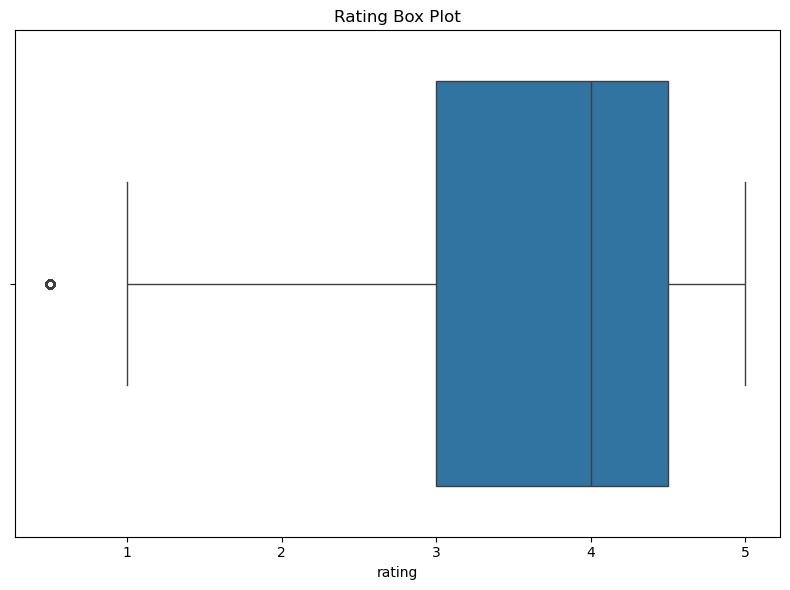

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure for the rating distribution
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed

# Boxplot for rating
sns.boxplot(x=final_pd_df["rating"], ax=ax)
ax.set_title("Rating Box Plot")

plt.tight_layout()
plt.show()




We see that all 0.5 ratings are considered as outliers.

Why I decided to keep 0.5 ratings: 
1. Reflects Genuine Opinions: Ratings of 0.5 likely represent highly dissatisfied users. These ratings provide important insights into extreme negative experiences with the product, service, or content being rated.
2. Avoiding Bias: If you remove or alter the 0.5 ratings, you risk biasing the data toward more positive outcomes, which might misrepresent user sentiment.

3.  ratings are subjective and reflect personal opinions.
4.  All correct values (not values outside 0.0-5.0)

# Big Data queries with SparkSQL

## Numeric features distribution

In [17]:
# Display numerical columns, 'rating' and 'year'
final_df.describe(["rating", "year"]).show()


+-------+------------------+------------------+
|summary|            rating|              year|
+-------+------------------+------------------+
|  count|           1433529|           1433529|
|   mean| 3.659652856691424|2001.4579140010421|
| stddev|1.1134979036785633|16.434769863786787|
|    min|               0.5|              1874|
|    max|               5.0|              2023|
+-------+------------------+------------------+



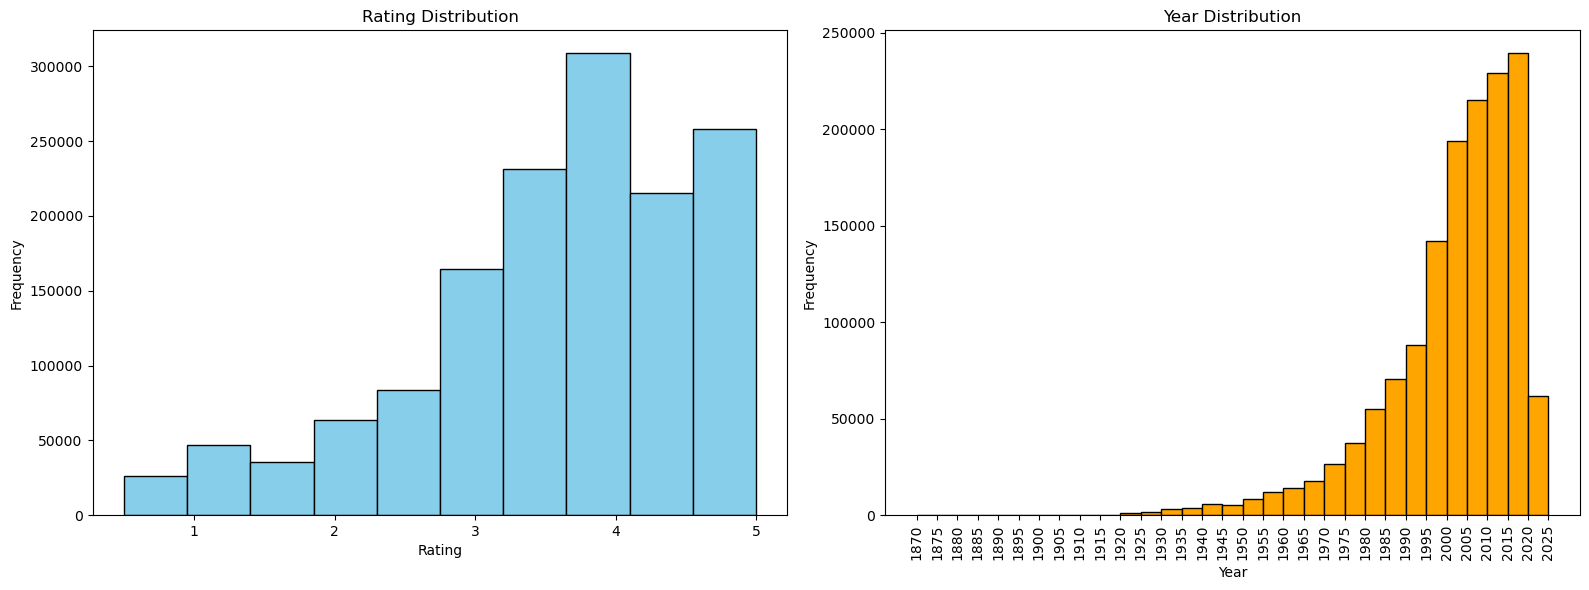

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'year' column to numeric, coercing errors (i.e., treating invalid values as NaN)
final_pd_df["year"] = pd.to_numeric(final_pd_df["year"], errors='coerce')

# Create subplots for rating and year distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot rating distribution
axes[0].hist(final_pd_df["rating"], bins=10, edgecolor="black", color="skyblue")
axes[0].set_title("Rating Distribution")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Frequency")

# Adjust the bins for the year distribution to start at 1870 or earlier for better visualization
year_bins = np.arange(1870, final_pd_df["year"].max() + 5, 5)

# Plot year distribution with custom bins (5-year intervals)
axes[1].hist(final_pd_df["year"].dropna(), bins=year_bins, edgecolor="black", color="orange")
axes[1].set_title("Year Distribution")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Frequency")
axes[1].set_xticks(year_bins)
axes[1].set_xticklabels(year_bins, rotation=90)

plt.tight_layout()
plt.show()



### Interpretation:

1. Rating Distribution: 
- Skewwed over toward the right side (peak of 4)
- Users tend to rate from 3 to 5 --> might indicate viewers rate their movie high because they actually finished it, it is less common to finish a movie you don't like

2. Year Distribution:
- Shows a clear upward trend in movie production (movies become more popular with time)
- A sharper rise around the 1990s and 2000s could indicate more modern films being present in the dataset.


## Common Genre

In [19]:
from pyspark.sql.functions import explode

# Explode the genres column to get individual genres 
genres_exploded = final_df.withColumn("genre", explode(final_df["genres"]))

# Count each genre occurrence
genres_count = genres_exploded.groupBy("genre").count().orderBy("count", ascending=False)
genres_count.show()



+------------------+------+
|             genre| count|
+------------------+------+
|             Drama|658194|
|          Thriller|436893|
|            Action|431426|
|            Comedy|387571|
|            Sci-Fi|357814|
|         Adventure|302877|
|             Crime|227324|
|            Horror|192002|
|           Romance|191391|
|           Fantasy|165289|
|           Mystery|150990|
|              IMAX| 83209|
|         Animation| 82865|
|          Children| 67435|
|               War| 58371|
|           Musical| 27708|
|       Documentary| 25929|
|           Western| 18055|
|         Film-Noir| 15590|
|(no genres listed)|  7281|
+------------------+------+



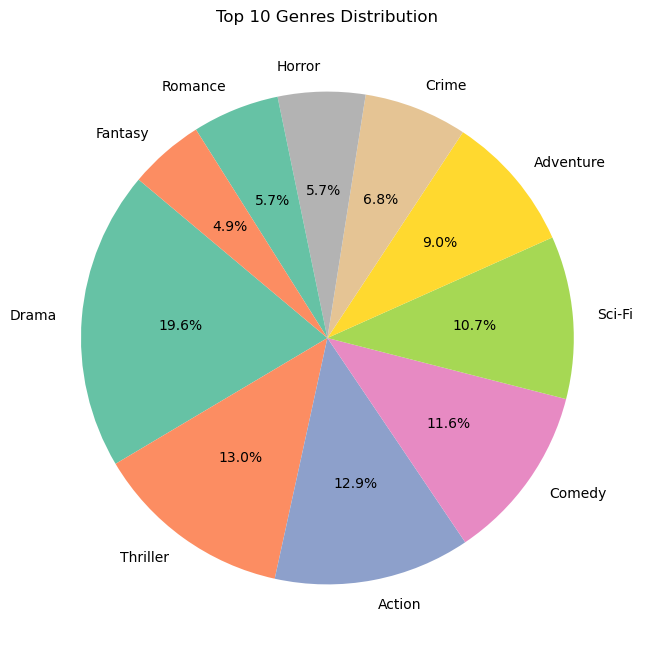

In [20]:
import seaborn as sns
# Convert Spark DataFrame to Pandas DataFrame
genres_count_pd = genres_count.toPandas()

# Limit to top genres for pie chart (e.g., top 10 genres)
top_genres = genres_count_pd.head(10)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_genres["count"], labels=top_genres["genre"], autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2"))
plt.title("Top 10 Genres Distribution")
plt.show()


## Top rating count of movies 

In [21]:
# Count how many times each movie has been rated
top_movies_by_ratings = final_df.groupBy("clean_title").count().orderBy("count", ascending=False)
top_movies_by_ratings.show(10)


+--------------------+-----+
|         clean_title|count|
+--------------------+-----+
|        Pulp Fiction| 6592|
|           Inception| 6500|
|         Matrix, The| 5639|
|        Interstellar| 5371|
|          Fight Club| 5340|
|Star Wars: Episod...| 5235|
|Shawshank Redempt...| 4785|
|             Memento| 3748|
|Eternal Sunshine ...| 3608|
|        Forrest Gump| 3481|
+--------------------+-----+
only showing top 10 rows



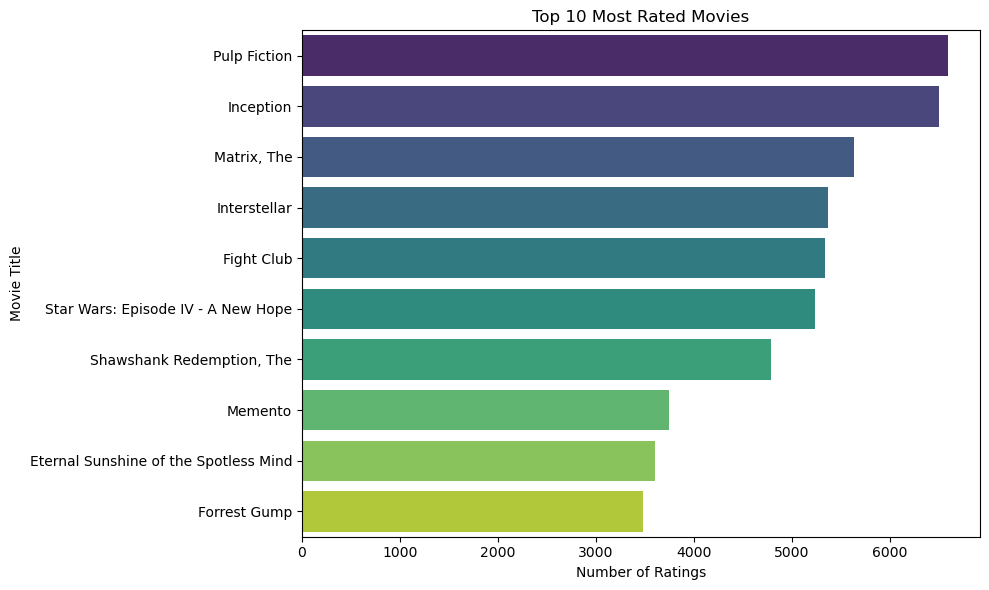

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the top 10 movies by ratings into a Pandas DataFrame
top_movies_by_ratings_pd = top_movies_by_ratings.limit(10).toPandas()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="clean_title", data=top_movies_by_ratings_pd, palette="viridis", hue="clean_title", dodge=False, legend=False)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")

# Show plot
plt.tight_layout()
plt.show()



## Top 10 movies with highest ratings (threshold: rating count > 1000)

In [23]:
from pyspark.sql.functions import avg, count

# Group movies by movieId and calculate the average rating and count the number of ratings
movie_ratings_df = final_df.groupBy("movieId", "clean_title") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("rating_count")
    )

# Set a threshold for the number of ratings (more than 1000)
threshold = 1000
filtered_movies_df = movie_ratings_df.filter(movie_ratings_df["rating_count"] > threshold)

# Sort movies by average rating in descending order
top_movies_df = filtered_movies_df.orderBy("avg_rating", ascending=False)

# Select the top 10 movies
top_10_movies_df = top_movies_df.limit(10)

# Show the result
top_10_movies_df.show(truncate=False)


+-------+-------------------------------------+------------------+------------+
|movieId|clean_title                          |avg_rating        |rating_count|
+-------+-------------------------------------+------------------+------------+
|318    |Shawshank Redemption, The            |4.6247648902821314|4785        |
|2959   |Fight Club                           |4.619850187265918 |5340        |
|1203   |12 Angry Men                         |4.530868167202573 |1555        |
|3147   |Green Mile, The                      |4.521501457725948 |1372        |
|44191  |V for Vendetta                       |4.521118498240125 |2557        |
|858    |Godfather, The                       |4.508374830239927 |2209        |
|202439 |Parasite                             |4.4983202687569985|2679        |
|7361   |Eternal Sunshine of the Spotless Mind|4.494733924611974 |3608        |
|2858   |American Beauty                      |4.490119971771348 |2834        |
|168252 |Logan                          

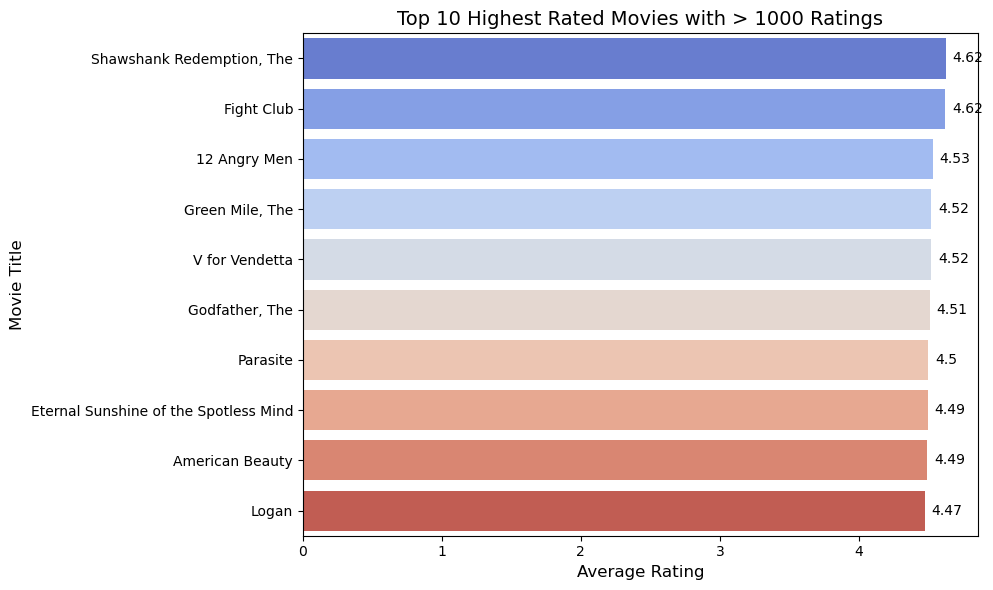

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the result to Pandas for visualization
top_10_movies_pd = top_10_movies_df.toPandas()

# Create a color palette using a gradient (e.g., "coolwarm" or "viridis")
palette = sns.color_palette("coolwarm", len(top_10_movies_pd))

# Create a bar plot to show the top 10 movies with better colors
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="avg_rating", y="clean_title", data=top_10_movies_pd, hue="clean_title", dodge=False, palette=palette, legend=False)

# Add the exact rating values at the end of each bar
for index, value in enumerate(top_10_movies_pd["avg_rating"]):
    barplot.text(value + 0.05, index, round(value, 2), color='black', va="center")

# Update the title and labels
plt.title("Top 10 Highest Rated Movies with > 1000 Ratings", fontsize=14)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)

# Show plot with tight layout
plt.tight_layout()
plt.show()


## Common Tag Cloud

In [25]:
# Count how many times each tag appears
top_tags = final_df.groupBy("tag").count().orderBy("count", ascending=False)
top_tags.show(10)


+------------------+-----+
|               tag|count|
+------------------+-----+
|            sci-fi|10487|
|       atmospheric| 9295|
|            action| 8036|
|            comedy| 7567|
|             funny| 7256|
|           surreal| 6947|
|visually appealing| 6863|
|      twist ending| 6345|
| thought-provoking| 5842|
|       dark comedy| 5654|
+------------------+-----+
only showing top 10 rows



In [26]:
!pip install wordcloud


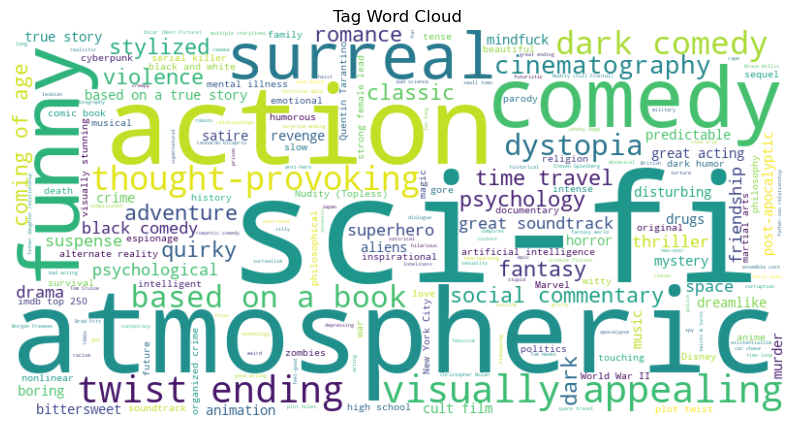

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Collect the top tags into a Pandas DataFrame
top_tags_pd = top_tags.toPandas()

# Create a dictionary of tag counts
tag_dict = dict(zip(top_tags_pd['tag'], top_tags_pd['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_dict)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tag Word Cloud")
plt.show()


## Average Rating per Genre

In [28]:
from pyspark.sql.functions import explode, avg

# Explode the genres array to get each genre in a separate row
genres_exploded = final_df.withColumn("genre", explode(final_df["genres"]))

# Group by genre and calculate the average rating
avg_rating_per_genre = genres_exploded.groupBy("genre").agg(avg("rating").alias("avg_rating"))

# Show the average rating per genre in PySpark DataFrame format
avg_rating_per_genre.show()


+------------------+------------------+
|             genre|        avg_rating|
+------------------+------------------+
|             Crime|3.8521845471661593|
|           Romance|3.7454425756697023|
|          Thriller|3.6457599457990857|
|         Adventure| 3.590247856390548|
|             Drama|3.8458668720772295|
|               War|3.8638621918418394|
|       Documentary|3.7131590111458213|
|           Fantasy| 3.658979121417638|
|           Mystery|3.7856016954765215|
|           Musical|3.8452793417063664|
|         Animation| 3.878953719905871|
|         Film-Noir|3.9324567030147533|
|(no genres listed)|3.3820903722016205|
|              IMAX|3.6587688831736953|
|            Horror|3.2751299465630566|
|           Western|3.7833564109664914|
|            Comedy| 3.627990742341403|
|          Children|3.6821680136427672|
|            Action|3.5428868450209308|
|            Sci-Fi|3.6129693080762633|
+------------------+------------------+



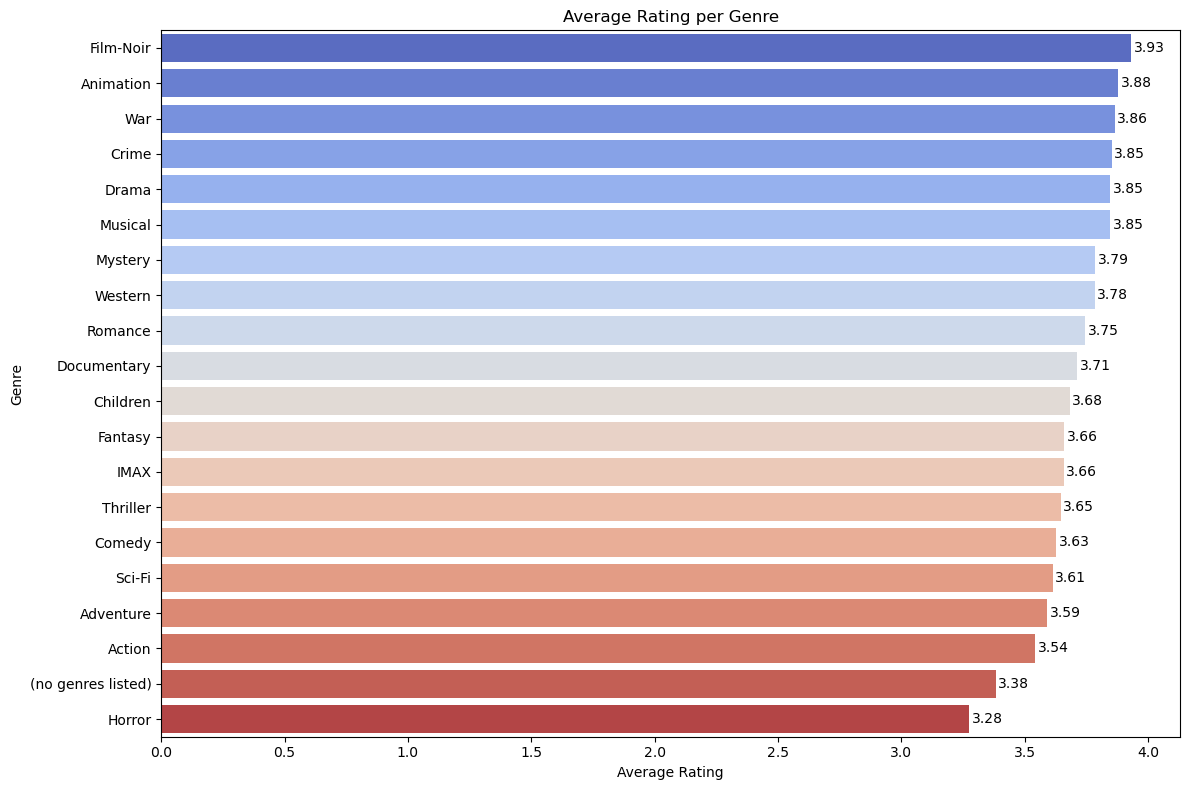

In [29]:
from pyspark.sql.functions import explode, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the result to Pandas for visualization
avg_rating_per_genre_pd = avg_rating_per_genre.toPandas()

# Sort the data for better visualization
avg_rating_per_genre_pd = avg_rating_per_genre_pd.sort_values(by="avg_rating", ascending=False)

# Plot the bar chart for average rating per genre
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x="avg_rating", y="genre", hue="genre", data=avg_rating_per_genre_pd, palette="coolwarm", dodge=False, legend=False)

# Add the exact average rating at the end of each bar
for index, value in enumerate(avg_rating_per_genre_pd["avg_rating"]):
    plt.text(value + 0.01, index, round(value, 2), color='black', va="center")

# Add title and labels
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")

# Show plot
plt.tight_layout()
plt.show()

## Genre Trend Over Time (Every Ten Years):

In [30]:
from pyspark.sql.functions import floor

# Create a new column for ten-year intervals
final_df = final_df.withColumn("year_interval", (floor(final_df["year"] / 10) * 10))

# Explode the genres array to get each genre in a separate row
genres_exploded = final_df.withColumn("genre", explode(final_df["genres"]))

# Group by genre and year_interval, then count the number of movies
genre_trend = genres_exploded.groupBy("year_interval", "genre").count()

# Show the top results to check
genre_trend.orderBy("year_interval", "count", ascending=False).show(20)


+-------------+------------------+------+
|year_interval|             genre| count|
+-------------+------------------+------+
|         2020|            Action| 24182|
|         2020|             Drama| 21695|
|         2020|          Thriller| 18001|
|         2020|            Comedy| 15997|
|         2020|            Sci-Fi| 14030|
|         2020|         Adventure| 14018|
|         2020|            Horror| 10565|
|         2020|           Fantasy|  9870|
|         2020|             Crime|  7228|
|         2020|           Mystery|  5693|
|         2020|         Animation|  4049|
|         2020|          Children|  3851|
|         2020|           Romance|  2705|
|         2020|       Documentary|  2132|
|         2020|               War|  1204|
|         2020|(no genres listed)|   382|
|         2020|           Western|   337|
|         2010|             Drama|204051|
|         2010|            Action|159141|
|         2010|            Sci-Fi|146854|
+-------------+------------------+

Show top 10 for better visualization

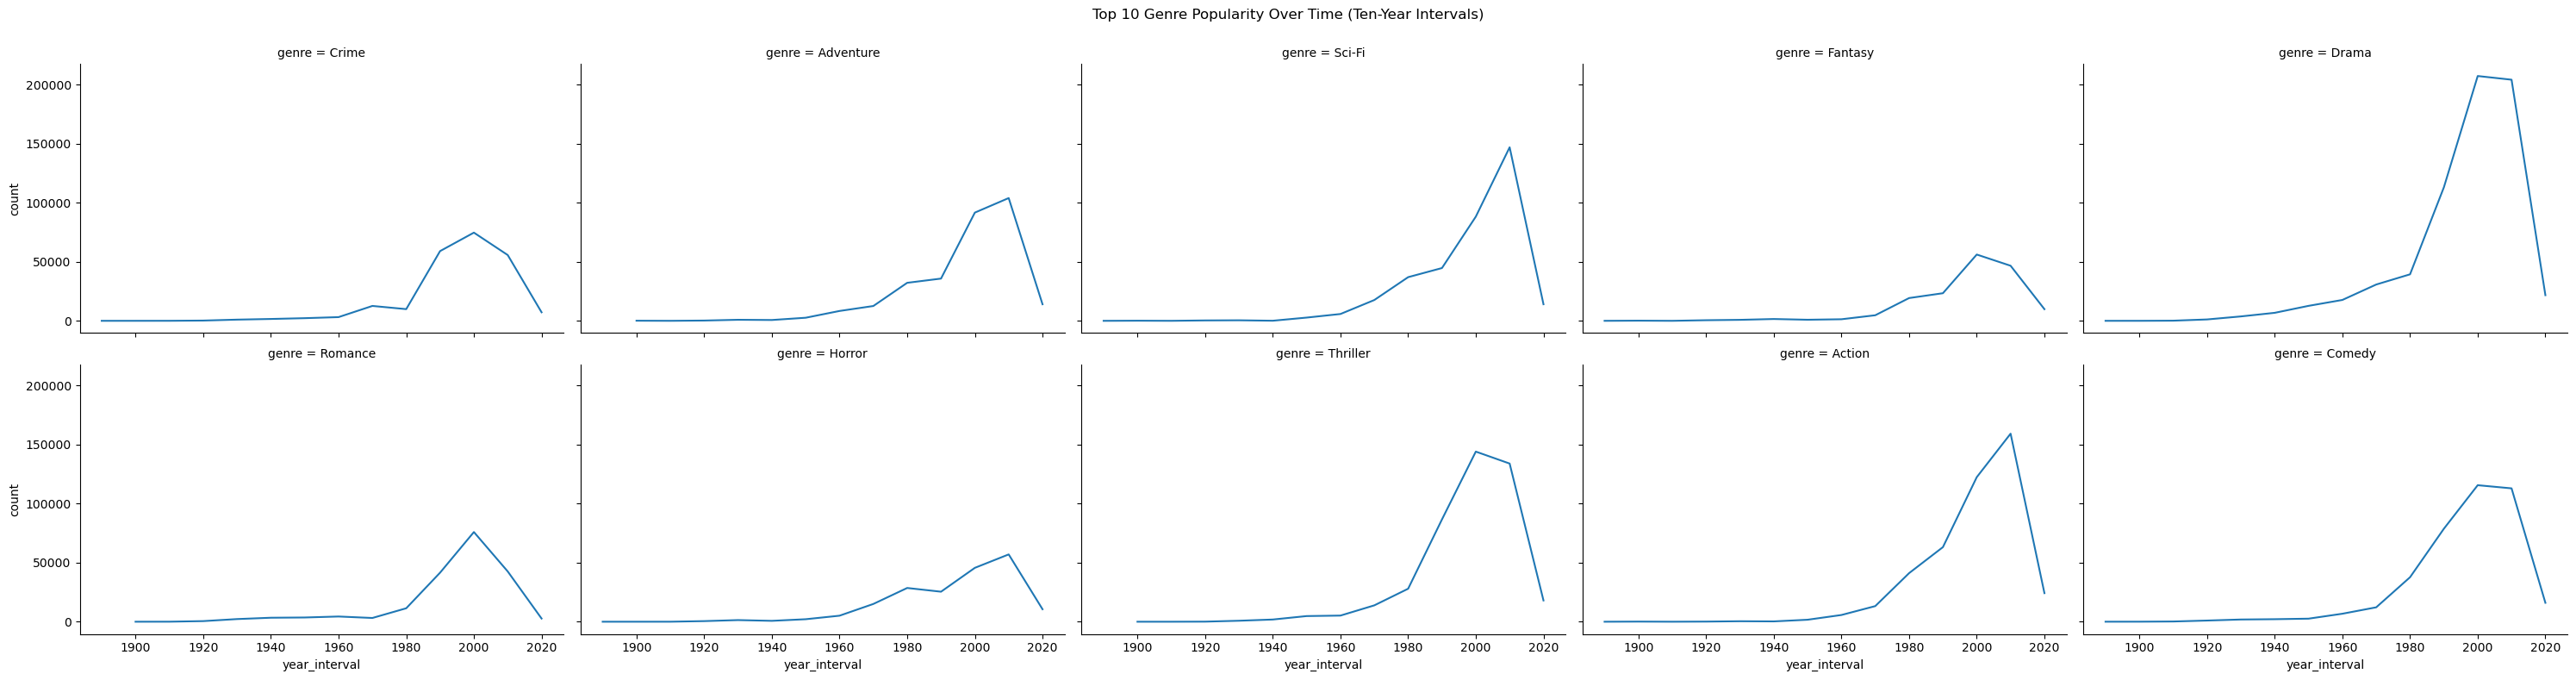

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
genre_trend_pd = genre_trend.toPandas()

# Filter the DataFrame to keep only the top 10 genres
top_10_genres = genre_trend_pd.groupby("genre").sum().nlargest(10, 'count').index
genre_trend_top10 = genre_trend_pd[genre_trend_pd['genre'].isin(top_10_genres)]

# Plot a FacetGrid of line charts for each genre
g = sns.FacetGrid(genre_trend_top10, col="genre", col_wrap=5, height=4, aspect=1.5)
g.map(sns.lineplot, "year_interval", "count")

# Add title and labels
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Genre Popularity Over Time (Ten-Year Intervals)")

plt.show()



### General Trends in Genre Popularity

- **Generally, Increase in Popularity**:
  - Across most genres, there is a notable **increase in the number of movies** produced after the **1970s**, peaking around the early **2000s**.
  - This might indicate a rise in **movie production** and **genre diversification** during this period.

- **Peak in the Early 2000s**:
  - Almost all genres see a significant **spike in popularity** between **1990 and 2010**, especially for genres like **Sci-Fi**, **Drama**, and **Action**.
  - This likely corresponds to a **boom in the film industry** and increasing audience interest in various genres.

- **Recent Decline**:
  - After the peak, some genres (e.g., **Crime**, **Romance**, **Horror**) show a **decline in popularity**.
  - This could indicate a **saturation** of films in these genres or a **shift in consumer preferences**.

- **Drop after 2020**:
  - Notice that the **drop after 2020** might be due to the **lack of data**. (Refer to the previous year distribution)


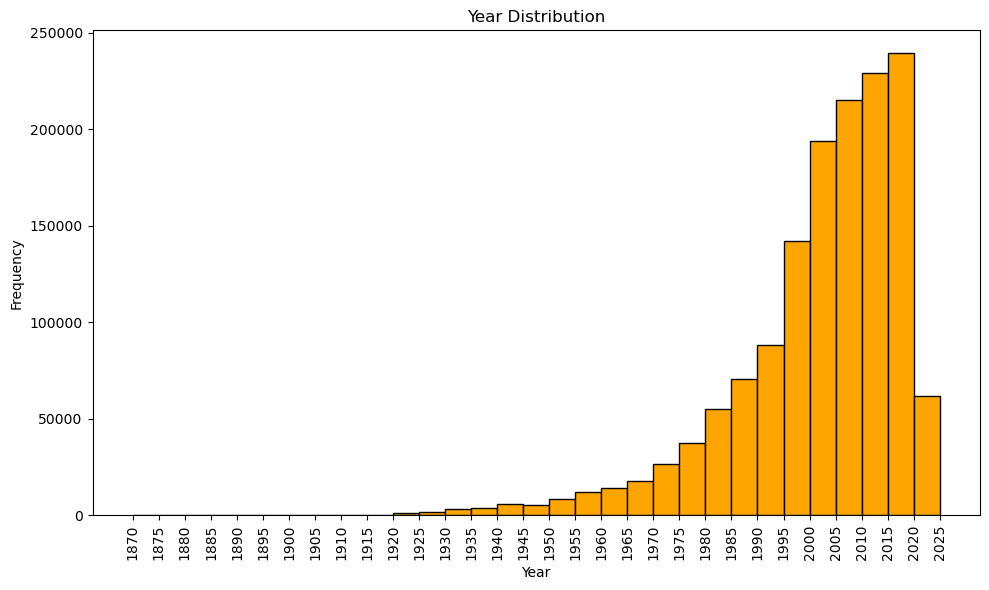

In [59]:
# Plot year distribution showcase
plt.figure(figsize=(10, 6))

# Adjust the bins for the year distribution to start at 1870 or earlier for better visualization
year_bins = np.arange(1870, final_pd_df["year"].max() + 5, 5)

# Plot year distribution with custom bins (5-year intervals)
plt.hist(final_pd_df["year"].dropna(), bins=year_bins, edgecolor="black", color="orange")
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(year_bins, rotation=90)

plt.tight_layout()
plt.show()


## Average Rating Over Time

In [33]:
# Calculate average rating per year
avg_rating_per_year = final_df.groupBy("year").avg("rating").orderBy("year")
avg_rating_per_year.show()


+----+------------------+
|year|       avg(rating)|
+----+------------------+
|1874|               5.0|
|1878|               5.0|
|1883|               3.0|
|1888|               2.5|
|1892|               2.5|
|1894|3.2222222222222223|
|1895|2.5816326530612246|
|1896|2.9766666666666666|
|1897|           3.14375|
|1898|3.1333333333333333|
|1899|3.3333333333333335|
|1900|3.1666666666666665|
|1901|               3.0|
|1902|3.7142857142857144|
|1903|2.9464285714285716|
|1904|3.1666666666666665|
|1905|              2.95|
|1906| 3.272727272727273|
|1907|               3.5|
|1908|3.3055555555555554|
+----+------------------+
only showing top 20 rows



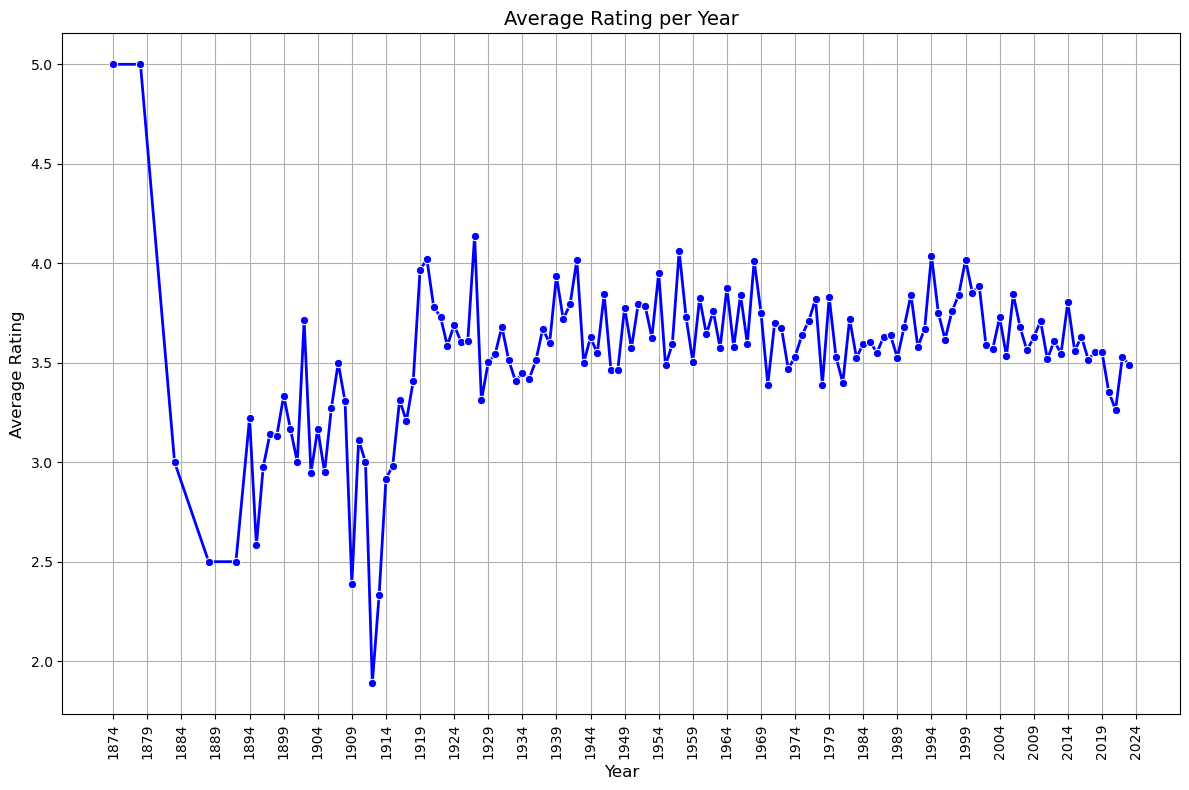

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for visualization
avg_rating_per_year_pd = avg_rating_per_year.toPandas()

# Convert 'year' column to integer
avg_rating_per_year_pd["year"] = pd.to_numeric(avg_rating_per_year_pd["year"], errors='coerce')

# Set plot size
plt.figure(figsize=(12, 8))

# Plot the line chart with improved visuals
sns.lineplot(x="year", y="avg(rating)", data=avg_rating_per_year_pd, marker="o", color="b", markersize=6, linewidth=2)

# Add title and labels
plt.title("Average Rating per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)

# Set x-axis ticks every 5 years and rotate the labels vertically
plt.xticks(ticks=range(1874, 2025, 5), rotation=90)  # Modified to start at 1874

# Add grid for clarity
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()





From the year distribution, data before 1919 might have been inaccurate because of the lack of data, resulting in fluctuation. Aside from that, there's a generally stable rating from 3.5 to 4.0.

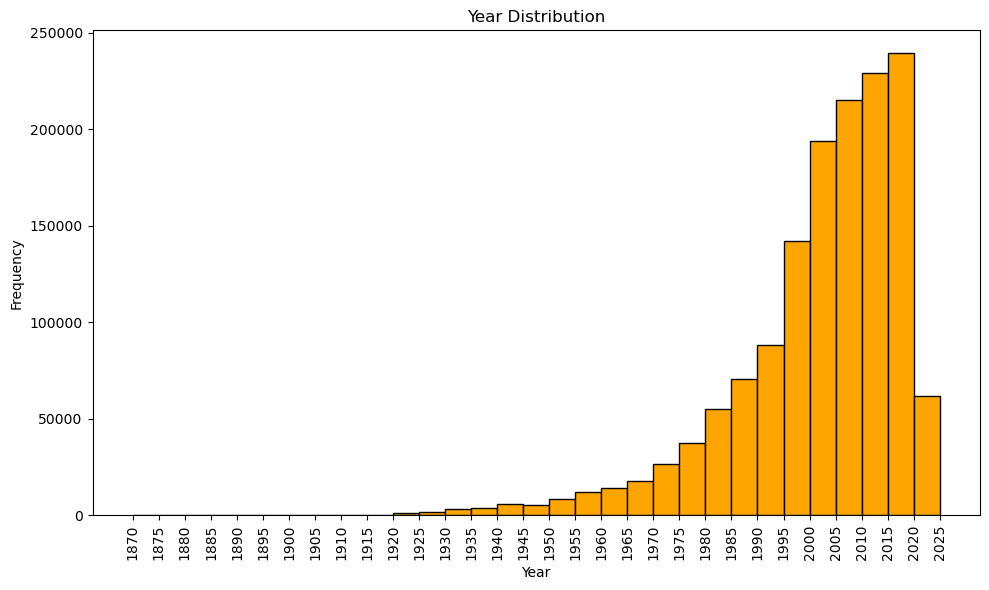

In [60]:
# Plot year distribution showcase
plt.figure(figsize=(10, 6))

# Adjust the bins for the year distribution to start at 1870 or earlier for better visualization
year_bins = np.arange(1870, final_pd_df["year"].max() + 5, 5)

# Plot year distribution with custom bins (5-year intervals)
plt.hist(final_pd_df["year"].dropna(), bins=year_bins, edgecolor="black", color="orange")
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(year_bins, rotation=90)

plt.tight_layout()
plt.show()


# Machine learning or data mining algorithms using Spark MLlib

## Clustering 

In [47]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col

# Cast the 'year' column to integer
final_df = final_df.withColumn("year", col("year").cast("int"))

# Select features for clustering
assembler = VectorAssembler(inputCols=["rating", "year"], outputCol="features")
feature_df = assembler.transform(final_df)

# Apply KMeans clustering
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(feature_df)
clusters = model.transform(feature_df)

# Show the cluster predictions
clusters.select("movieId", "rating", "year", "prediction").show()

# Create a summary DataFrame to analyze each cluster
cluster_summary = clusters.groupBy("prediction") \
    .agg({"year": "avg", "rating": "avg", "movieId": "count"}) \
    .withColumnRenamed("avg(year)", "avg_year") \
    .withColumnRenamed("avg(rating)", "avg_rating") \
    .withColumnRenamed("count(movieId)", "movie_count")

cluster_summary.show()


+-------+------+----+----------+
|movieId|rating|year|prediction|
+-------+------+----+----------+
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   3.5|1995|         2|
|      1|   4.5|1995|         2|
|      1|   4.5|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
|      1|   4.0|1995|         2|
+-------+------+----+----------+
only showing top 20 rows

+----------+------------------+------------------+-----------+
|prediction|          avg_year|        avg_rating|movie_count|
+----------+------------------+------------------+------

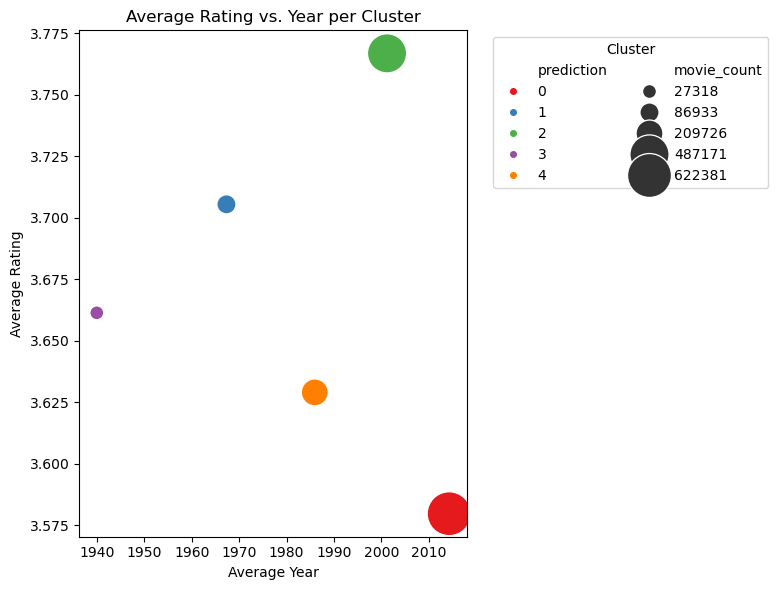

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert cluster summary to Pandas for visualization
cluster_summary_pd = cluster_summary.toPandas()

# Scatter plot showing the relationship between average year and average rating for each cluster
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(x="avg_year", y="avg_rating", size="movie_count", hue="prediction", data=cluster_summary_pd, palette="Set1", sizes=(100, 1000))

# Add titles and labels
plt.title("Average Rating vs. Year per Cluster")
plt.xlabel("Average Year")
plt.ylabel("Average Rating")

# Place the legend outside the plot and make it longer
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)  # 'ncol=2' for a longer legend

# Show plot
plt.tight_layout()
plt.show()



- **Cluster 2 (Green)**:
  - Represents movies with the **highest average ratings** (~3.775).
  - Primarily includes films from the **1980s to 2000s**.

- **Cluster 0 (Red)**:
  - Represents the **lowest-rated movies** (~3.575).
  - Mainly consists of movies from the **most recent period (2010+)**.

- **Cluster 4 (Orange)**:
  - Contains a **large number of movies**, but with **somewhat lower average ratings** (~3.625).
  - Movies in this cluster are from the **1970s**.

 - **Recent movies (2010+) tend to have lower ratings** compared to older films.

## Classification

Random Forest Accuracy: 0.5993462477343922
Precision: 0.6058741493663476
Recall: 0.5993462477343922
F1 Score: 0.6009964699963628


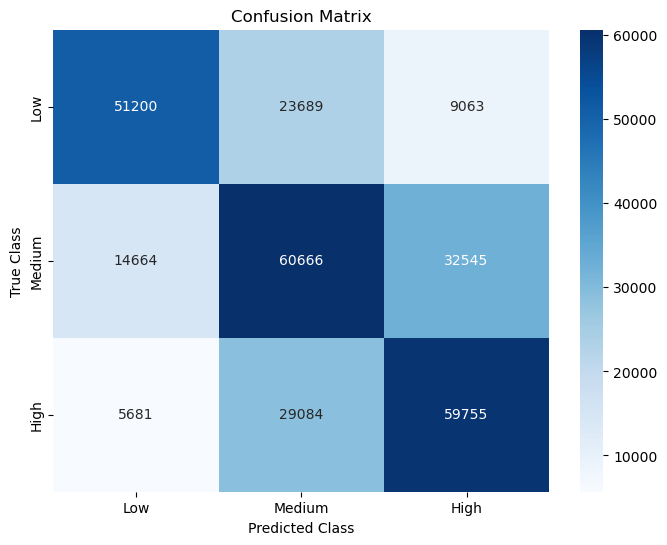

+-------+----------------+------------+----------+
|movieId|      avg_rating|rating_class|prediction|
+-------+----------------+------------+----------+
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|           0|       1.0|
|      1|3.91183879093199|     

In [49]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import concat_ws, when, avg, count
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Combine the array of genres into a single string for each row
indexed_df = final_df.withColumn("genres_combined", concat_ws("|", "genres"))

# 2. Index the 'genres_combined' column for machine learning
indexer = StringIndexer(inputCol="genres_combined", outputCol="genres_indexed")
indexed_df = indexer.fit(indexed_df).transform(indexed_df)

# 3. Create labels for classification based on the rating (high/medium/low) with non-negative integer labels
indexed_df = indexed_df.withColumn("rating_class", 
                                   when(indexed_df["rating"] > 4.0, 2)   # High -> 2
                                   .when(indexed_df["rating"] > 3.0, 1)  # Medium -> 1
                                   .otherwise(0))                       # Low -> 0

# 4. Calculate rating count and average rating for each movie
movie_stats = indexed_df.groupBy("movieId").agg(count("rating").alias("rating_count"), avg("rating").alias("avg_rating"))

# 5. Join the movie stats with the indexed DataFrame
indexed_df = indexed_df.join(movie_stats, on="movieId", how="left")

# 6. Select the necessary columns explicitly to avoid ambiguity and disambiguate duplicate column names
indexed_df = indexed_df.select(indexed_df["movieId"], 
                               indexed_df["year"], 
                               indexed_df["genres_indexed"], 
                               indexed_df["rating_class"], 
                               movie_stats["rating_count"], 
                               movie_stats["avg_rating"])

# 7. Assemble features (now including 'rating_count' and 'avg_rating')
assembler = VectorAssembler(inputCols=["year", "genres_indexed", "rating_count", "avg_rating"], outputCol="features")
feature_df = assembler.transform(indexed_df)

# 8. Split the data into training and testing sets
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)

# 9. Train a Random Forest Classifier with an increased maxBins parameter
rf = RandomForestClassifier(featuresCol="features", labelCol="rating_class", numTrees=100, maxBins=1500)
rf_model = rf.fit(train_df)

# 10. Make predictions on the test set
rf_predictions = rf_model.transform(test_df)

# 11. Evaluate the Random Forest model
evaluator = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# 12. Additional evaluation metrics for Random Forest
# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(rf_predictions)
print(f"Precision: {precision}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="weightedRecall")
recall = recall_evaluator.evaluate(rf_predictions)
print(f"Recall: {recall}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="f1")
f1 = f1_evaluator.evaluate(rf_predictions)
print(f"F1 Score: {f1}")

# 13. Visualize Confusion Matrix
rf_predictions_pd = rf_predictions.select("rating_class", "prediction").toPandas()
conf_matrix = confusion_matrix(rf_predictions_pd["rating_class"], rf_predictions_pd["prediction"])

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# 14. Show predictions (Random Forest)
rf_predictions.select("movieId", "avg_rating", "rating_class", "prediction").show()







### Model Performance Overview

- **Current Performance**: 
  - The model is performing **modestly**, but there is **room for improvement**.
  
- **Misclassification Issues**:
  - Misclassifications are relatively common, especially between **adjacent classes** like:
    - **Low → Medium**
    - **Medium → High**
    
- **Consistent Misclassification**:
  - Certain movies, such as the one displayed in the table, are **consistently misclassified**.
  - This could indicate potential issues with:
    - **Feature selection or engineering**.
    - The **complexity of the dataset**.

## Regression

In [50]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Random Forest Regressor with increased maxBins to handle large categorical feature
rf = RandomForestRegressor(featuresCol="features", labelCol="avg_rating", maxBins=1500)  # Increase maxBins

# Fit the model
rf_model = rf.fit(train_df)

# Predictions
predictions = rf_model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="avg_rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")




RMSE: 0.097879662508152


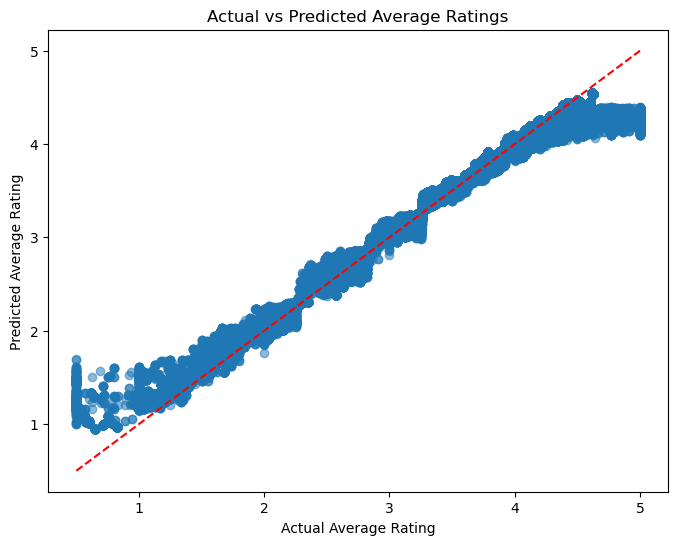

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for easier visualization
predictions_pd = predictions.select("avg_rating", "prediction").toPandas()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["avg_rating"], predictions_pd["prediction"], alpha=0.5)
plt.plot([predictions_pd["avg_rating"].min(), predictions_pd["avg_rating"].max()],
         [predictions_pd["avg_rating"].min(), predictions_pd["avg_rating"].max()],
         color='red', linestyle='--')  # Line representing perfect predictions
plt.xlabel("Actual Average Rating")
plt.ylabel("Predicted Average Rating")
plt.title("Actual vs Predicted Average Ratings")
plt.show()


### Regression Line Fit

- The plot shows **good alignment** between **actual** and **predicted ratings**, especially for **higher ratings** (around 3 to 5).
- Most points closely follow the **red dashed line**, which represents **perfect predictions**.
- The **red dashed line** is the ideal scenario where the **predicted average rating** equals the **actual average rating**.
- The scatter points being closely aligned with this line indicates that the **regression model** is making **good predictions overall**.

---

### Lower Ratings Prediction

- For **lower ratings** (1 to 2), there is a bit more **spread** in the predicted values.
- However, this region still shows a general **trend of improvement** as actual values increase, despite slightly more **variance**.

---

### RMSE (0.0988)

- The **Root Mean Square Error (RMSE)** measures the **average magnitude of prediction errors**.
- An RMSE of **0.0988** is quite low, indicating that the model's predictions are, on average, very close to the actual ratings.
- This suggests that the **regression model** is performing **very well** at predicting average ratings, as the **error margin** is small.

---

### Conclusion

- The **regression model** is performing **quite well**, with a strong alignment between actual and predicted ratings and a **low RMSE**.
- The scatter plot further reinforces that predictions for **higher ratings** are more accurate, while there is slightly more variability for **lower ratings**.


## Association rule mining

In [52]:
from pyspark.sql.functions import collect_list, flatten, array_distinct
from pyspark.ml.fpm import FPGrowth

# Prepare transactions of genres (flatten the nested array and ensure distinct genres)
transactions_df = final_df.groupBy("movieId").agg(array_distinct(flatten(collect_list("genres"))).alias("genres_list"))

# FP-Growth model
fp_growth = FPGrowth(itemsCol="genres_list", minSupport=0.01, minConfidence=0.1)
fp_model = fp_growth.fit(transactions_df)

# Frequent itemsets
fp_model.freqItemsets.show()

# Association rules
fp_model.associationRules.show()



+--------------------+-----+
|               items| freq|
+--------------------+-----+
|            [Sci-Fi]| 2315|
|  [Sci-Fi, Thriller]|  622|
|    [Sci-Fi, Horror]|  571|
|    [Sci-Fi, Action]|  835|
|    [Sci-Fi, Comedy]|  400|
|     [Sci-Fi, Drama]|  462|
|            [Action]| 3585|
|  [Action, Thriller]| 1188|
|[Action, Thriller...|  352|
|    [Action, Comedy]|  717|
|     [Action, Drama]| 1063|
|           [Musical]|  633|
|   [Musical, Comedy]|  308|
|         [Animation]| 1447|
|[Animation, Fantasy]|  372|
| [Animation, Comedy]|  477|
|[Animation, Adven...|  435|
|             [Drama]|12310|
|           [Western]|  422|
|            [Horror]| 3327|
+--------------------+-----+
only showing top 20 rows

+-------------------+-----------+-------------------+------------------+--------------------+
|         antecedent| consequent|         confidence|              lift|             support|
+-------------------+-----------+-------------------+------------------+------------------

### Frequent Itemsets Table:
- This table lists **combinations of genres** (itemsets) and their frequencies.
  - Example: **Sci-Fi** appears in **2,315 movies**, and the combination **Sci-Fi, Thriller** appears in **622 movies**.
- These itemsets help identify **common genre combinations** in the dataset.

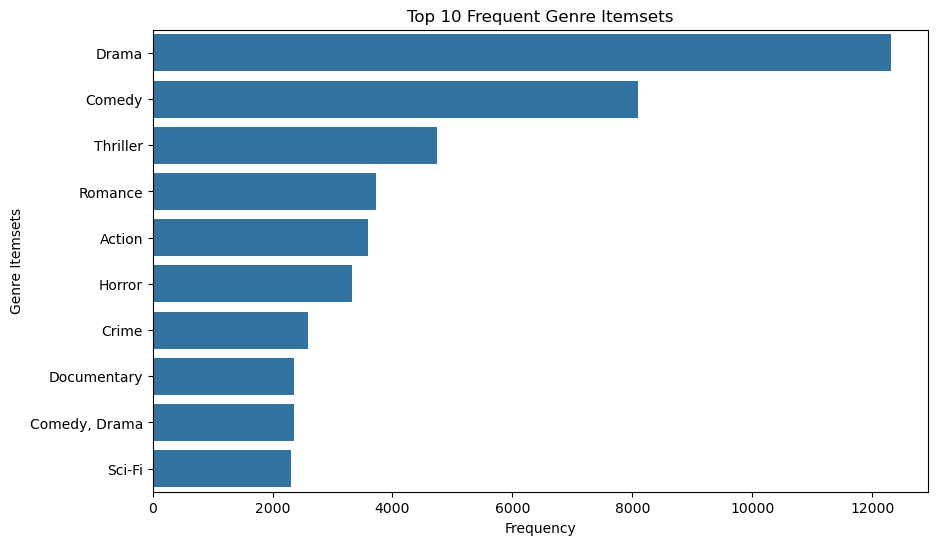

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the frequent itemsets to a Pandas DataFrame
freq_itemsets_df = fp_model.freqItemsets.toPandas()

# Convert the 'items' column from lists to strings for plotting
freq_itemsets_df["items_str"] = freq_itemsets_df["items"].apply(lambda x: ', '.join(x))

# Sort the itemsets by frequency in descending order
freq_itemsets_df = freq_itemsets_df.sort_values(by="freq", ascending=False)

# Plot the top 10 frequent itemsets
plt.figure(figsize=(10, 6))
sns.barplot(x="freq", y="items_str", data=freq_itemsets_df.head(10))
plt.title("Top 10 Frequent Genre Itemsets")
plt.xlabel("Frequency")
plt.ylabel("Genre Itemsets")
plt.show()



### Top 10 Frequent Genre Itemsets (Bar Chart):
- **Drama** is the most frequent genre, appearing in over **12,000 movies**, followed by **Comedy** with about **8,000 appearances**.
- Other popular genres include **Thriller**, **Romance**, **Action**, and **Horror**.
- This **bar chart** helps visualize the **most common genres** in the dataset.

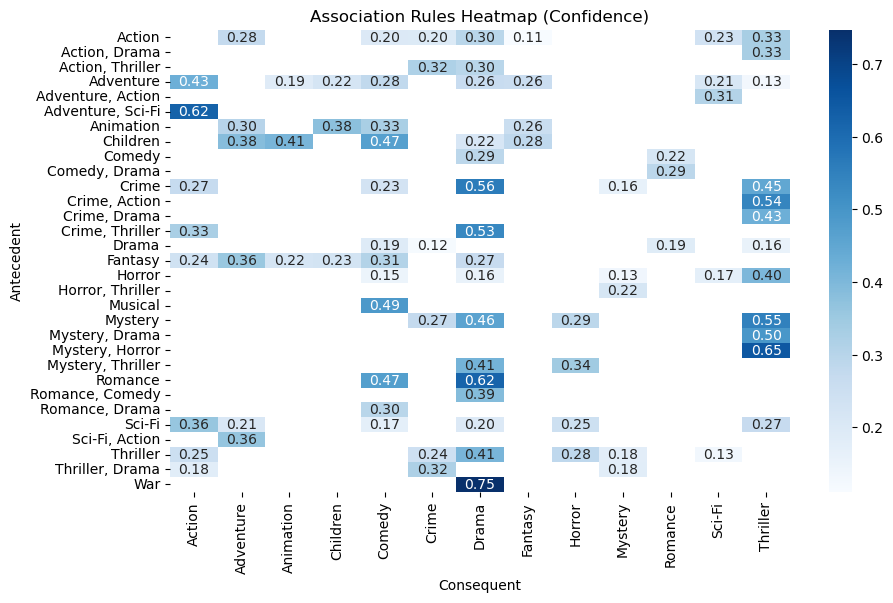

In [54]:
# Convert the association rules to a Pandas DataFrame
association_rules_df = fp_model.associationRules.toPandas()

# Convert the 'antecedent' and 'consequent' columns from lists to strings for plotting
association_rules_df["antecedent_str"] = association_rules_df["antecedent"].apply(lambda x: ', '.join(x))
association_rules_df["consequent_str"] = association_rules_df["consequent"].apply(lambda x: ', '.join(x))

# Sort by confidence
association_rules_df = association_rules_df.sort_values(by="confidence", ascending=False)

# Prepare the data for heatmap (using confidence as values)
plt.figure(figsize=(10, 6))
rules_matrix = pd.pivot_table(association_rules_df, values="confidence", index="antecedent_str", columns="consequent_str", aggfunc='mean')

# Plot heatmap
sns.heatmap(rules_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Association Rules Heatmap (Confidence)")
plt.xlabel("Consequent")
plt.ylabel("Antecedent")
plt.show()


### Association Rules Heatmap (Confidence):
- This **heatmap** shows the **confidence levels** of association rules between genres.
  - Example: **Adventure, Sci-Fi (antecedent)** has a confidence score of **0.62** with the **Sci-Fi (consequent)**.
    - This means that when a movie has **Adventure and Sci-Fi**, there's a **62% chance** the movie also belongs to the **Sci-Fi genre**.
- The highest confidence value in the heatmap is **0.75**, suggesting that if a movie belongs to **Drama**, it is very likely to also belong to **War**.
- **Confidence** tells how often items in the **antecedent** appear in transactions that also contain the **consequent**.

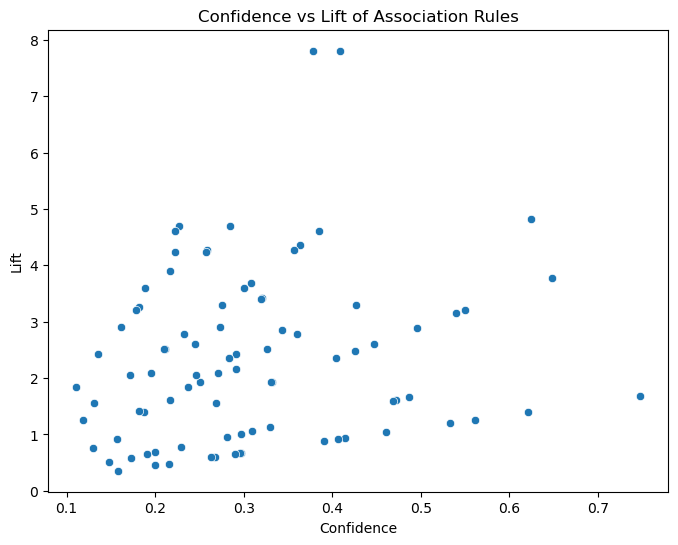

In [55]:
# Plot scatter plot of confidence vs lift
plt.figure(figsize=(8, 6))
sns.scatterplot(x="confidence", y="lift", data=association_rules_df)
plt.title("Confidence vs Lift of Association Rules")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.show()


###  Confidence vs. Lift Scatter Plot:
- This scatter plot compares the confidence and lift values of association rules.
- Lift measures how much more likely the items in the consequent are observed together than if they were randomly associated. Values greater than 1 indicate a strong association.
- Some rules have both high lift and high confidence, indicating strong relationships between genres, while others may have lower confidence and lift values.